In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image

from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO  
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

### § 8.1.1 Regression Trees

In [3]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 41.1+ KB


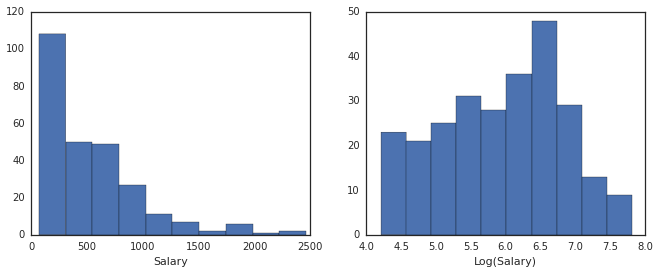

In [4]:
X = df[['Years', 'Hits']].as_matrix()
y = np.log(df.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.as_matrix())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)')

In [11]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

In [12]:
regr.tree_.value

array([[[ 5.92722154]],

       [[ 5.10678961]],

       [[ 6.35403584]],

       [[ 5.99837985]],

       [[ 6.73968692]]])

In [13]:
regr.tree_.threshold

array([   4.5,   -2. ,  117.5,   -2. ,   -2. ])

###Figure 8.1

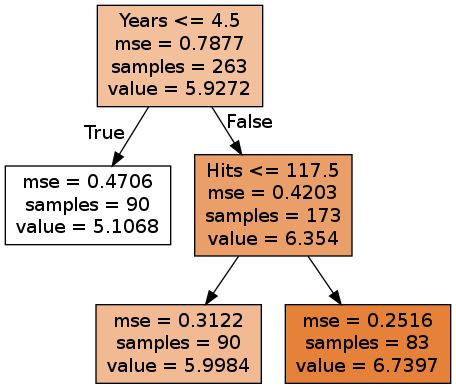

In [14]:
dot_data = StringIO() 
tree.export_graphviz(regr, out_file=dot_data, feature_names=['Years', 'Hits'], filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

###  Figure 8.2

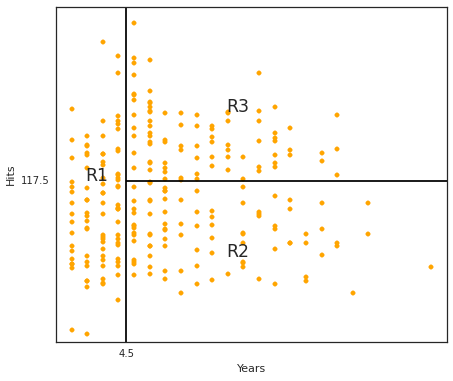

In [15]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([4.5])
plt.yticks([117.5])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large')

### Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
    

### § 8.1.2 Classification Trees

In [20]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null object
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null object
AHD          297 non-null object
dtypes: float64(2), int64(9), object(3)
memory usage: 31.3+ KB


In [21]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [22]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [40]:
clf = tree.DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=6, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [41]:
clf.score(X2,y2)

0.7407407407407407

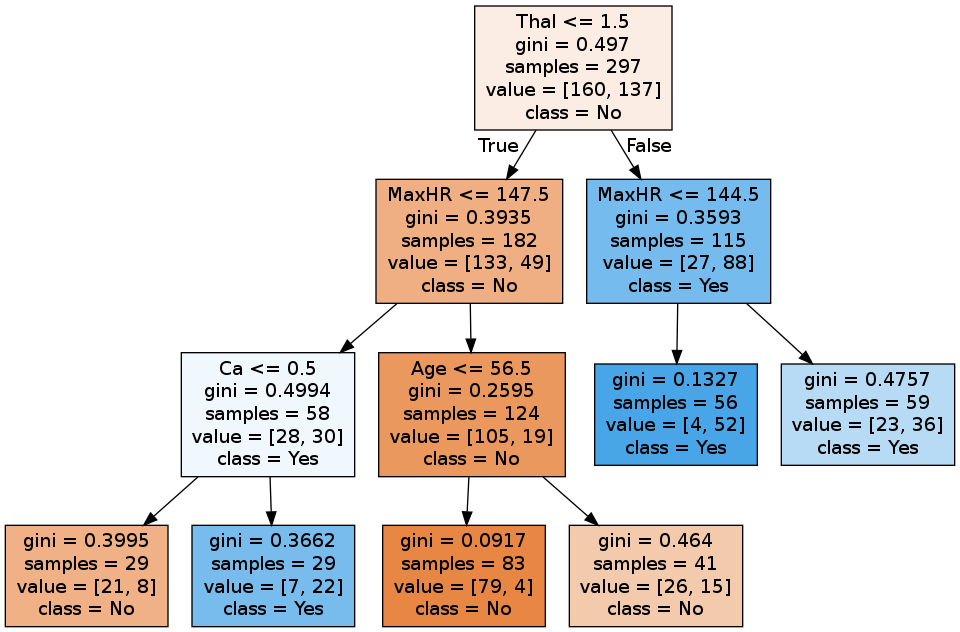

In [207]:
dot_data2 = StringIO() 
tree.export_graphviz(clf, out_file=dot_data2, feature_names=np.array(X2.columns), class_names=['No', 'Yes'], filled=True)
graph2 = pydot.graph_from_dot_data(dot_data2.getvalue())
Image(graph2.create_png())

### § 8.2.2 Random Forests

In [99]:
clf2 = RandomForestClassifier(n_estimators=50, max_depth=3)
clf2.fit(X2,y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
clf2.score(X2,y2)

0.87878787878787878

In [101]:
clf2.feature_importances_

array([  3.87723285e-02,   3.32248858e-02,   1.14337139e-01,
         2.79398139e-02,   2.73284152e-02,   1.14801064e-04,
         8.22192088e-03,   1.29914836e-01,   9.33648168e-02,
         1.26655779e-01,   5.66672053e-02,   1.93714178e-01,
         1.49743881e-01])

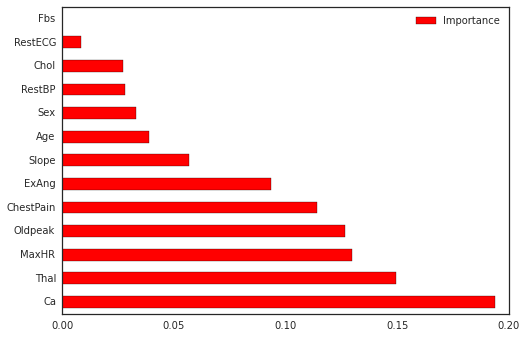

In [102]:
Importance = pd.DataFrame({'Importance':clf2.feature_importances_}, index=X2.columns)
Importance.sort('Importance', axis=0, ascending=False).plot(kind='barh', color='r', )

## Lab

### § 8.3.1 Fitting Classification Trees

In [102]:
df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3['High'] = df3.Sales.map(lambda x: 1 if x > 8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
df3.Urban = pd.factorize(df3.Urban)[0]
df3.US = pd.factorize(df3.US)[0]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 12 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null int32
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null int32
US             400 non-null int32
High           400 non-null int64
dtypes: float64(1), int32(3), int64(8)
memory usage: 35.9 KB


In [107]:
df3.head()

   Sales  CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0   9.50        138      73           11         276    120          0   42   
1  11.22        111      48           16         260     83          1   65   
2  10.06        113      35           10         269     80          2   59   
3   7.40        117     100            4         466     97          2   55   
4   4.15        141      64            3         340    128          0   38   

   Education  Urban  US  High  
0         17      0   0     1  
1         10      0   0     1  
2         12      0   0     1  
3         14      0   0     0  
4         13      0   1     0  

In [210]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

In [243]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [244]:
clf.score(X,y)

0.76749999999999996

In [241]:
clf.tree_.n_features

10

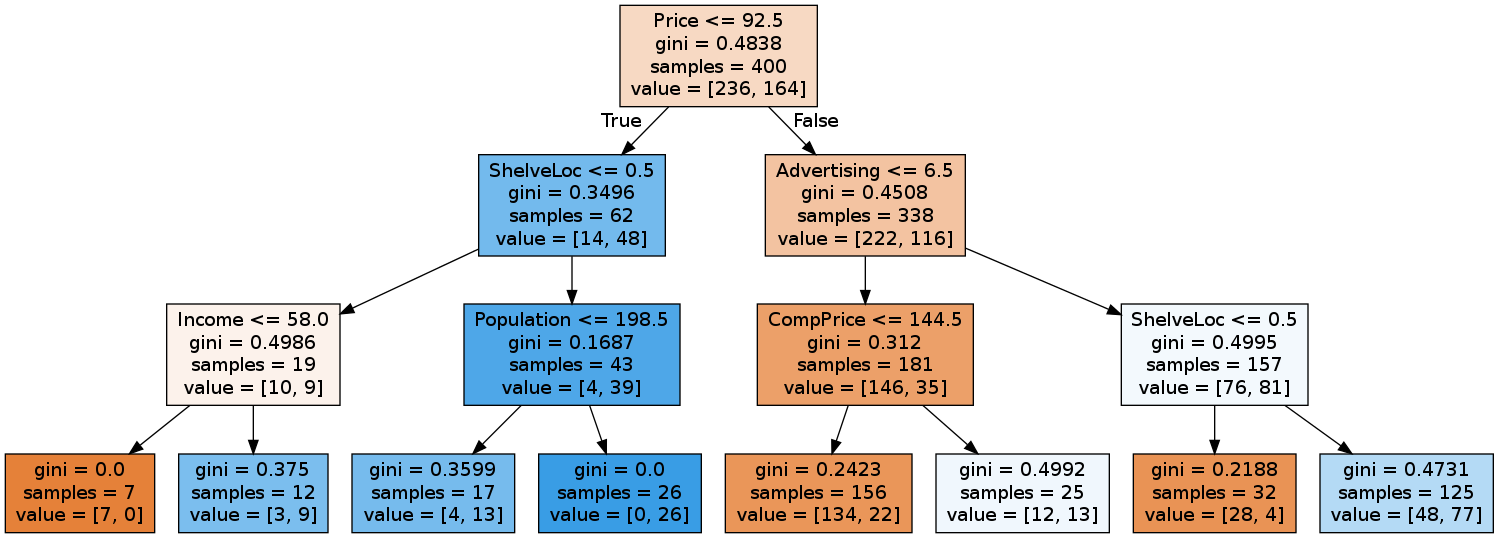

In [245]:
dot_data3 = StringIO() 
tree.export_graphviz(clf, out_file=dot_data3, feature_names=np.array(X.columns), filled=True)
graph3 = pydot.graph_from_dot_data(dot_data3.getvalue())
Image(graph3.create_png())